# Digit Classifier w/ PyTorch

We are going to do a few things here:

- We want to train a model to identify digits for the individual sudoku cell image that the Recognizer has prepared.
- We want to use this as a Tensorflow Model in the C++

So what are the steps?

1. First train the sudoku digit classifier (aka SudokuNet) model using the MNIST dataset
2. Save the model to the /models folder as a .pb file

## Part I: Setup

### Dependencies

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score

### Prepare the dataset

In [37]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
lr_step_gamma = 0.7
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Get the dataset

In [3]:
# prep training dataset
train_dataset = torchvision.datasets.MNIST(
    './dataset', train=True, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size_train, 
    shuffle=True
)

# prep test dataset
test_dataset = torchvision.datasets.MNIST(
    './dataset', 
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ]))

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size_test, 
    shuffle=True
)

100.1%

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Plot some samples

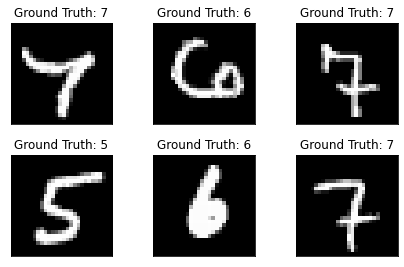

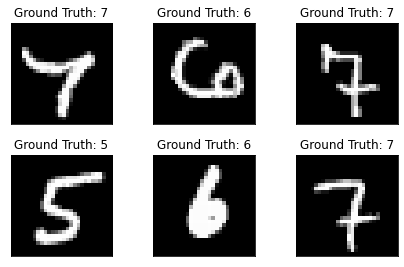

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Part II: Build the model

### Setup

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### Create the model

In [28]:
class SudokuNet(nn.Module):
    def __init__(self):
        super(SudokuNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Setup training

## Part III: Train the model

In [30]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [55]:
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

def train(model, epoch, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), './models/model.pth')
      torch.save(optimizer.state_dict(), './models/optimizer.pth')

In [56]:
model = SudokuNet()
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

for epoch in range(1, n_epochs + 1):
    train(model, epoch, optimizer)
    test(model)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304408
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.315722
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.297674
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.292122
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.303820
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.308620
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.295024
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.317907
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.308458
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.302550
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.281121
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.304714
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.295491
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.289749
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.289761
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.306260
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.282298
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.298188
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.289312
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.299911
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.312710
Train Epoch: 2 [45440/60000 (76%)]	Loss: 2.314729
Train Epoch: 2 [46080/60000 (77%)]	Loss: 2.301115
Train Epoch: 2 [46720/60000 (78%)]	Loss: 2.317662
Train Epoch: 2 [47360/60000 (79%)]	Loss: 2.311439
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.301976
Train Epoch: 2 [48640/60000 (81%)]	Loss: 2.316561
Train Epoch: 2 [49280/60000 (82%)]	Loss: 2.298466
Train Epoch: 2 [49920/60000 (83%)]	Loss: 2.294756
Train Epoch: 2 [50560/60000 (84%)]	Loss: 2.290611
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.314969
Train Epoch: 2 [51840/60000 (86%)]	Loss: 2.305789
Train Epoch: 2 [52480/60000 (87%)]	Loss: 2.307512
Train Epoch: 2 [53120/60000 (88%)]	Loss: 2.298409
Train Epoch: 2 [53760/60000 (90%)]	Loss: 2.307837
Train Epoch: 2 [54400/60000 (91%)]	Loss: 2.309788
Train Epoch: 2 [55040/60000 (92%)]	Loss: 2.309898
Train Epoch: 2 [55680/60000 (93%)]	Loss: 2.309121
Train Epoch: 2 [56320/60000 (94%)]	Loss: 2.292130
Train Epoch: 2 [56960/60000 (95%)]	Loss: 2.296915


Train Epoch: 4 [28800/60000 (48%)]	Loss: 2.292940
Train Epoch: 4 [29440/60000 (49%)]	Loss: 2.304184
Train Epoch: 4 [30080/60000 (50%)]	Loss: 2.305822
Train Epoch: 4 [30720/60000 (51%)]	Loss: 2.306401
Train Epoch: 4 [31360/60000 (52%)]	Loss: 2.306067
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.303639
Train Epoch: 4 [32640/60000 (54%)]	Loss: 2.291969
Train Epoch: 4 [33280/60000 (55%)]	Loss: 2.300966
Train Epoch: 4 [33920/60000 (57%)]	Loss: 2.303765
Train Epoch: 4 [34560/60000 (58%)]	Loss: 2.296005
Train Epoch: 4 [35200/60000 (59%)]	Loss: 2.292669
Train Epoch: 4 [35840/60000 (60%)]	Loss: 2.295856
Train Epoch: 4 [36480/60000 (61%)]	Loss: 2.290114
Train Epoch: 4 [37120/60000 (62%)]	Loss: 2.291241
Train Epoch: 4 [37760/60000 (63%)]	Loss: 2.291286
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.304090
Train Epoch: 4 [39040/60000 (65%)]	Loss: 2.303486
Train Epoch: 4 [39680/60000 (66%)]	Loss: 2.301451
Train Epoch: 4 [40320/60000 (67%)]	Loss: 2.300151
Train Epoch: 4 [40960/60000 (68%)]	Loss: 2.315921


## Part IV: Evaluate performance & further training

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Continued training

In [ ]:
continued_model = SudokuNet()
continued_optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
model_state_dict = torch.load("./models/model.pth")
continued_network.load_state_dict(model_state_dict)

optimizer_state_dict = torch.load("./models/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

## Prep to save the model to be used in C++

In [ ]:
example_image, example_label = next(iter(train_loader))
# run the tracing
traced_script_module = torch.jit.trace(model, example_image)
# save the converted model
traced_script_module.save("./models/converted_model.pt")